In [20]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import os, urllib, itertools, shutil, random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix
import PIL

In [21]:
path_to_folder = '/Users/argosaakan/Data/snakes_dataset' # Указать свой путь к папке с csv файлами
os.chdir(path_to_folder)

In [22]:
# Функция для обрисовки матрицы сопряжения
def plot_confusion_matrix(cm, classes,normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Функция для получения списка изображений из тестовой выборки
def get_random_test_imgs():
    random_test_imgs = []
    for idx, _ in enumerate(classes):
        if idx == 0:
            row = random.sample(range(0, test_for_class - 1), columns)
        else:
            row = random.sample(range(test_for_class * idx, test_for_class * (idx + 1) - 1), columns)
            
        random_test_imgs.extend(row)

    return random_test_imgs

In [23]:
classes = ['natrix', 'viper', 'smooth', 'random']

def get_sets_amount(valid_x, test_x):
    count_images = 0

    folders = [x for x in os.listdir(path_to_folder) if not x.startswith(".")]
    for folder in folders:
        path = os.path.join(path_to_folder, folder)
        for image in os.listdir(path):
            image_path = os.path.join(path, image)
            if os.path.isfile(image_path) and not image.startswith("."):
                count_images += 1

    valid_amount = int(count_images * valid_x)
    test_amount = int(count_images * test_x)
    train_amount = count_images - valid_amount - test_amount

    return train_amount, valid_amount, test_amount

train_amount, valid_amount, test_amount = get_sets_amount(0.15, 0.05)
valid_for_class = round(valid_amount / len(classes))
test_for_class = round(test_amount / len(classes))

print(f'Train images: {train_amount}\nValid images: {valid_amount}\nTest images: {test_amount}')

Train images: 1281
Valid images: 239
Test images: 79


In [24]:
# Разделим изображения на train, valid и test, разложим по папкам
# random.seed(0)
os.chdir(path_to_folder)
if os.path.isdir('train') is False:

    os.mkdir('valid')
    os.mkdir('test')

    for name in classes:
        shutil.copytree(f'{name}', f'train/{name}')
        os.mkdir(f'valid/{name}')
        os.mkdir(f'test/{name}')

        valid_samples = random.sample(os.listdir(f'train/{name}'), round(valid_amount / len(classes)))
        for j in valid_samples:
            shutil.move(f'train/{name}/{j}', f'valid/{name}')
        
        test_samples = random.sample(os.listdir(f'train/{name}'), round(test_amount / len(classes)))
        for k in test_samples:
            shutil.move(f'train/{name}/{k}', f'test/{name}')

    print('Created train, valid and test directories')

os.chdir('../..')

Created train, valid and test directories


In [25]:
# Создадим генераторы train, valid и test и предпобработаем изображения для mobilenet
batch_size = 20
train_path = os.path.join(path_to_folder, 'train')
valid_path = os.path.join(path_to_folder, 'valid')
test_path = os.path.join(path_to_folder, 'test')
target_size = (224, 224)

train_batches = ImageDataGenerator(preprocessing_function=keras.applications.densenet.preprocess_input).flow_from_directory(directory=train_path, target_size=target_size, classes=classes, batch_size=batch_size)

valid_batches = ImageDataGenerator(preprocessing_function=keras.applications.densenet.preprocess_input).flow_from_directory(directory=valid_path, target_size=target_size, classes=classes, batch_size=batch_size)

test_batches = ImageDataGenerator(preprocessing_function=keras.applications.densenet.preprocess_input).flow_from_directory(directory=test_path, target_size=target_size, classes=classes, batch_size=batch_size, shuffle=False)

Found 1278 images belonging to 4 classes.
Found 240 images belonging to 4 classes.
Found 80 images belonging to 4 classes.


In [26]:
# Загрузим предобученную модель
mobile_net = keras.applications.DenseNet121()

In [27]:
# Посмотрим на предобученную модель, выберем какие из последних слоев будем заменять
# mobile_net.summary()

_bn[0][0]          
__________________________________________________________________________________________________
conv5_block4_1_conv (Conv2D)    (None, 7, 7, 128)    77824       conv5_block4_0_relu[0][0]        
__________________________________________________________________________________________________
conv5_block4_1_bn (BatchNormali (None, 7, 7, 128)    512         conv5_block4_1_conv[0][0]        
__________________________________________________________________________________________________
conv5_block4_1_relu (Activation (None, 7, 7, 128)    0           conv5_block4_1_bn[0][0]          
__________________________________________________________________________________________________
conv5_block4_2_conv (Conv2D)    (None, 7, 7, 32)     36864       conv5_block4_1_relu[0][0]        
__________________________________________________________________________________________________
conv5_block4_concat (Concatenat (None, 7, 7, 640)    0           conv5_block3_concat[0][0

In [28]:
# Оставим все слои кроме последних пяти. 
# Добавим выходной слой с активационной функцией softmax для определения класса
x = mobile_net.layers[-1].output
output = Dense(len(classes), activation='softmax')(x)

model = Model(inputs=mobile_net.input, outputs=output)

In [29]:
# При обучении будем работать с весами последних 23 слоев
for layer in model.layers[:-24]:
    layer.trainable = False

In [30]:
# Определим раннюю остановку обучения, компилируем модель
early_stopping = keras.callbacks.EarlyStopping(
    patience=7,
    min_delta=0.001,
    restore_best_weights=True,
)

model.compile(
    optimizer='Adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [31]:
%%time
# Обучаем модель
history = model.fit(
    x=train_batches, 
    validation_data=valid_batches, 
    epochs=50, 
    callbacks=[early_stopping]
)

Epoch 1/50
64/64 [==============================] - 121s 2s/step - loss: 1.3583 - accuracy: 0.5097 - val_loss: 1.2857 - val_accuracy: 0.8125
Epoch 2/50
64/64 [==============================] - 113s 2s/step - loss: 1.2505 - accuracy: 0.8658 - val_loss: 1.2035 - val_accuracy: 0.8125
Epoch 3/50
64/64 [==============================] - 113s 2s/step - loss: 1.1472 - accuracy: 0.9073 - val_loss: 1.1494 - val_accuracy: 0.7792
Epoch 4/50
64/64 [==============================] - 116s 2s/step - loss: 1.0754 - accuracy: 0.9046 - val_loss: 1.0359 - val_accuracy: 0.8833
Epoch 5/50
64/64 [==============================] - 115s 2s/step - loss: 0.9740 - accuracy: 0.9514 - val_loss: 0.9726 - val_accuracy: 0.8875
Epoch 6/50
64/64 [==============================] - 115s 2s/step - loss: 0.9077 - accuracy: 0.9543 - val_loss: 0.9332 - val_accuracy: 0.8667
Epoch 7/50
64/64 [==============================] - 116s 2s/step - loss: 0.8447 - accuracy: 0.9552 - val_loss: 0.8634 - val_accuracy: 0.8875
Epoch 8/50
64

<AxesSubplot:title={'center':'Accuracy'}>

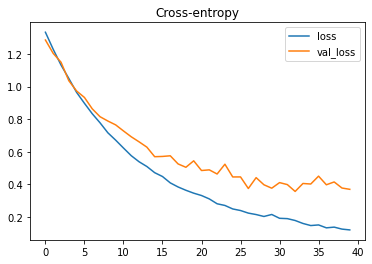

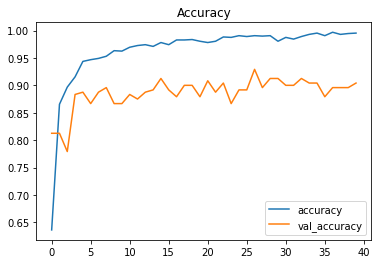

In [32]:
# Посмотрим на график функции потерь (на train и valid). Хочется минимизировать val loss, 
# при этом не переобучить модель на train set. 
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title="Accuracy")

In [33]:
# Проверяем accuracy на изображениях, которые модель ранее не видела
scores = model.evaluate(test_batches)
print(f'Accuracy: {round((scores[1]*100), 2)}%')

4/4 [==============================] - 7s 2s/step - loss: 0.4288 - accuracy: 0.9000
Accuracy: 90.0%


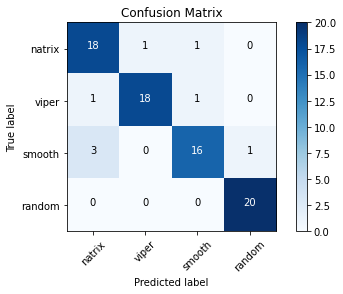

In [34]:
# Строим матрицу сопряженности
preds = model.predict(test_batches)
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(preds, axis=1))
plot_confusion_matrix(cm=cm, classes=classes, title='Confusion Matrix')

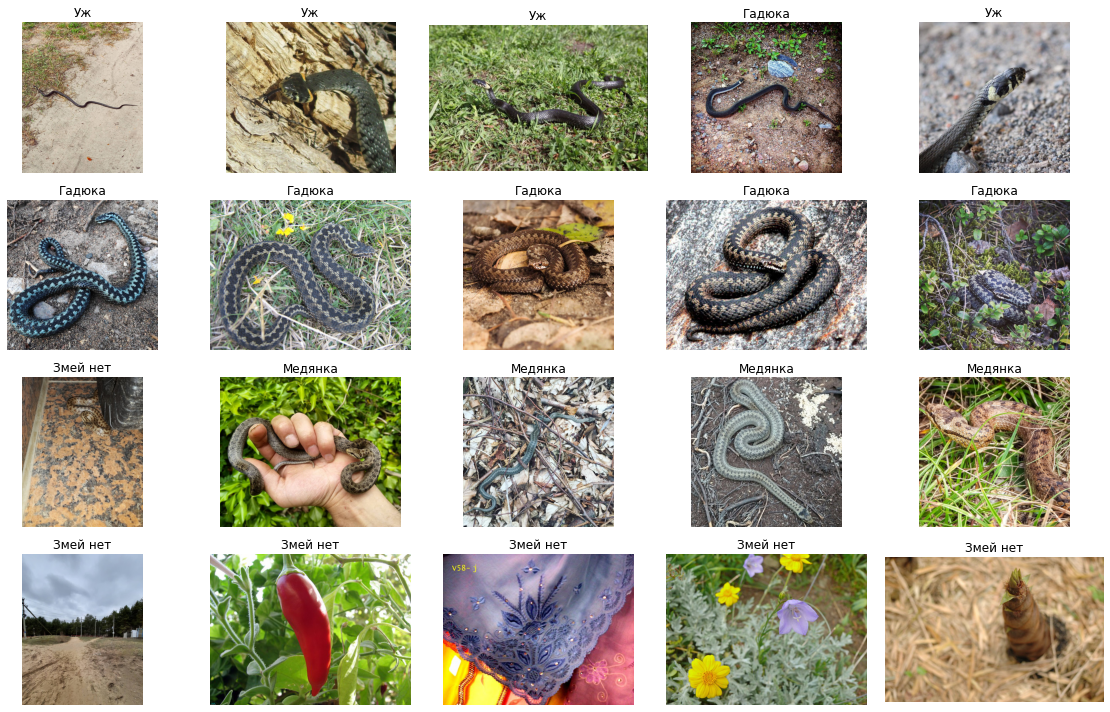

In [35]:
preds_catigorical = pd.Series(np.argmax(preds, axis=1)).replace({0: 'Уж', 1: 'Гадюка', 2: 'Медянка', 3: 'Змей нет'})
columns = 5

fig, ax = plt.subplots(nrows=len(classes), ncols=columns, figsize=[16, 10])
random_test_imgs = get_random_test_imgs()

for i, axi in enumerate(ax.flat):
    image = PIL.Image.open(test_batches.filepaths[random_test_imgs[i]])
    axi.imshow(image)
    axi.set_title(preds_catigorical[random_test_imgs[i]])
    axi.axis('off')
    plt.tight_layout()

plt.show()

In [36]:
# model.save('/Users/argosaakan/Desktop/Projects/jup/snakes')